# Project NoteBook
## Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project are available in the local repository for this project ([GitHub link](https://github.com/CCThompson82/Prostate_metastasis/tree/master/Dataset_setup)).  If run locally, two [feather](https://github.com/wesm/feather) files will be written to the working directory, which will be read and imported with the python scripts below.

In [1]:
%run -i Dataset_cleanup/cleanup_clinical.py

Clinical data set imported!

 The following features do not provide any information: 
 ['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 

Variables that are not known at initial diagnosis: 
 ['daystodeath' 'daystolastfollowup' 'daystopsa' 'histologicaltype'
 'numberoflymphnodes' 'pathologyTstage' 'radiationtherapy' 'residualtumor'
 'vitalstatus'] 

Variables that are known at the time of diagnosis:
 ['dateofinitialpathologicdiagnosis' 'gleasonscore' 'psavalue' 'race'
 'yearstobirth']

Dimensions of clinical dataframe: (499, 5)


In [2]:
%run -i Dataset_cleanup/cleanup_gene_counts.py

Gene Counts data set imported!

Dimension of DataFrame: (497, 20501) 

Transformation Successful!

497 Gene count estimate profiles have been transformed from transcript abundance estimates to transcripts per million reads (TPM)


## Dataset preparation
### Clinical Information
There is missing clinical data in many of the features, including what will become the outcome label ('pathologyNstage' - metastasis state).  The series **'y_all'** is the full list of pathologyNstage, where 'n1' represents metastasis, and 'n0' represents no metastasis observed to date.  Some observations have no metastasis state recorded and are represented by NaN in y_all.  These are removed for the trimmed **'y_labels'** series.  

The **'clinical'** dataset is trimmed to include only those patients where a metastasis state is known.  Then the data set is trimmed further to remove observations where feature data is missing to yield the dataframe, **'clin_df'**.  Finally, 'y_labels' is trimmed to only those patients that exist in 'clin_df' to yield, **'y_clin'**.

In [3]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y_labels = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y_labels.shape[0])
print("\nUnlabeled observations (removed:)",not_labeled.shape[0])


Total observations in original dataset: 499

Observations with metastasis label: 426

Unlabeled observations (removed:) 73


In [4]:
clinical = clinical.loc[y_labels.index]  #filter only observations where metastasis state is known
print("Filtering out missing metastasis state labels left",clinical.shape[0],"observations")

clin_df = clinical.dropna(inplace = False) # Remove all observations where clinical data is missing
print("Removing NaN rows leaves ",clin_df.shape[0]," observations in the feature set.") 

y_clin = y_labels.loc[clin_df.index] #remove metastasis labels where no clinical data now exists due to NaN removal.

Filtering out missing metastasis state labels left 426 observations
Removing NaN rows leaves  359  observations in the feature set.


### TPM dataset
The original dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  This dataset is trimmed to include only those observations where a finite y label exists, to yield **'X'**.  Additionally, X_all was scaled to mean = zero, standard variance as **'X_scaled_all'**.  This data set was trimmed to the relevant observations in **'X_scaled'**.  Finally, a test was run to ensure barcodes were not duplicated in the base, 'X' data set. 

In [5]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[list(y_labels.index)]  #Only observations that also have a known metastasis state are kept.
X.dropna(axis=0, inplace=True)

In [6]:
"""Scale TPM counts in X to mean = 0 and standard variance"""
from sklearn.preprocessing import scale
X_scaled_all = pd.DataFrame(scale(X_all), columns = X_all.columns, index = [X_all.index])
X_scaled = X_scaled_all.loc[X.index]

In [7]:
"""Ensure target labels correspond to an observation in X"""
y = y_labels[X.index] #only labels that are in X are kept.  
y_all = y_all[X_all.index]


In [8]:
"""Test on DataFrame"""
print('No duplicates in index:',X.index.is_unique)

No duplicates in index: True


## Analysis
### Data Exploration

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

### Exploratory Visualization

In [10]:
"""Data needs slight transformation for informative graphical analysis"""
psa_floor = []
for psa in clin_df['psavalue'] :
    if psa == 0 :
        psa += 0.01
    psa_floor.append(psa)
clin_df['psavalue'] = np.log10(psa_floor)  #All 0 values for PSA replaced with 0.01 as to not be NaN upon log10 transformation

Dataset_cleanup/cleanup_gene_counts.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


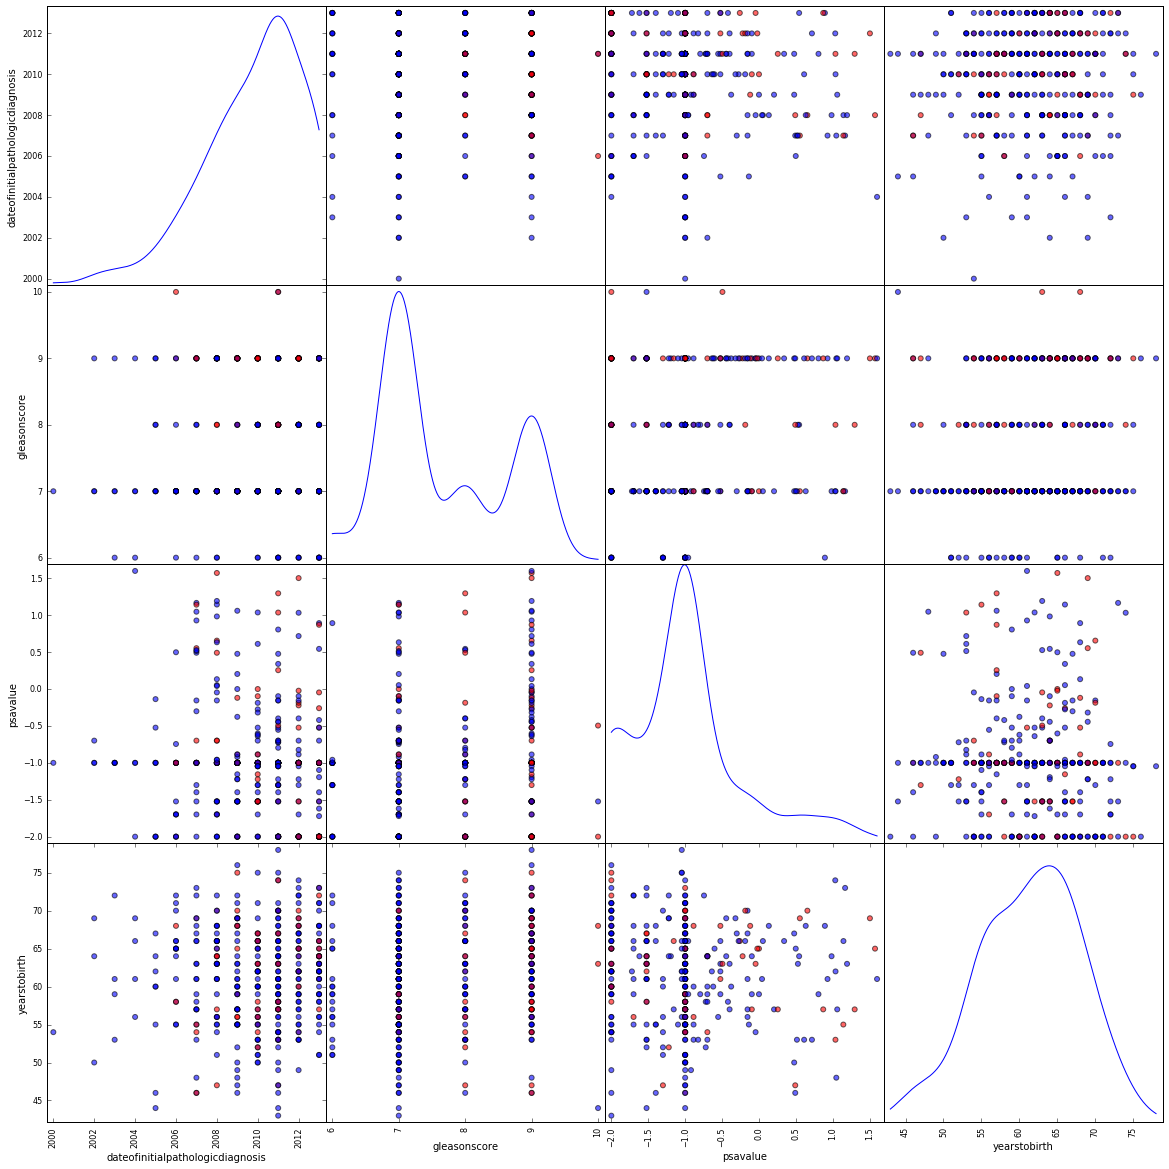

In [11]:
colours = list(y_clin.replace({'n1':'red', 'n0': 'blue'}))
sm = pd.scatter_matrix(clin_df, 
                       alpha=0.6,
                       s= 100,
                       c = colours,
                       figsize= (20,20), 
                       diagonal = 'kde')

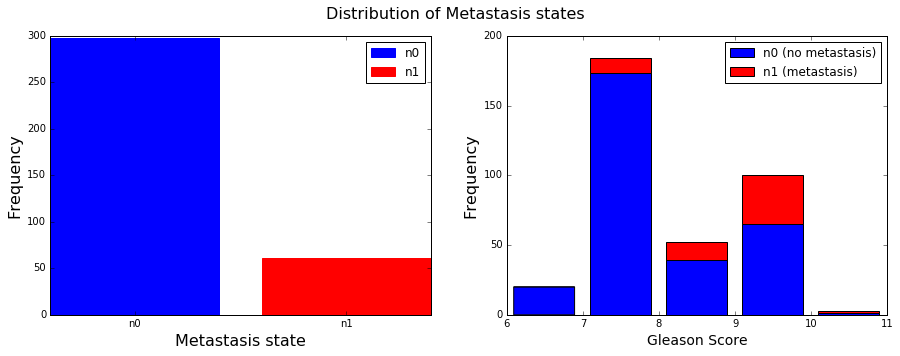

In [12]:
D = {'n0': sum(y_clin == 'n0'), 'n1': sum(y_clin == 'n1')}
exp_fig = plt.figure(figsize=(15,5))
B = exp_fig.add_subplot(1,2,1)
A = exp_fig.add_subplot(1,2,2)
bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
x_multi = [clin_df.loc[y_clin[y_clin == 'n0'].index]['gleasonscore'], 
           clin_df.loc[y_clin[y_clin == 'n1'].index]['gleasonscore']]
A.hist(x_multi, bins, label = ['n0 (no metastasis)', 'n1 (metastasis)'], color = ['blue','red'], stacked = True)
A.set_xlabel('Gleason Score', fontsize = 14)
A.legend(loc='best')
exp_fig.suptitle('Distribution of Metastasis states', fontsize=16)
A.set_ylabel('Frequency',fontsize=16)
ind = B.bar(range(0,2), height= D.values(), align='center')
B.set_xticks(range(0,2))
B.set_xticklabels(D.keys())
B.set_ylabel('Frequency', fontsize=16)
B.set_xlabel('Metastasis state', fontsize=16)
ind[0].set_color('b')
ind[0].set_label('n0')
ind[1].set_color('red')
ind[1].set_label('n1')
B.legend(loc='best')
ep = plt.show

### Algorithms and Techniques

### Benchmark 
#### Analysis of initial clinical presentation for  predictors of metastasis

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, matthews_corrcoef, fbeta_score, classification_report

In [14]:
"""Scorers needed throughout code:"""
matthews_cor_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

In [15]:
"""Use only features available to the doctor at presentation for benchmark classifier"""
clin_df.drop(['race', 'gleasonscore'],axis=1, inplace=True)  #Gleason Score is not available at time of biospy and thus dropped
clf_DT = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=None,
                            min_samples_split=30, #basic parameter change to avoid overfitting
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            random_state=None,
                            max_leaf_nodes=None,
                            class_weight='balanced', #avoids the classifier being rewarded for choosing the most prevelant class each instance (n0)
                            presort=False)

Dataset_cleanup/cleanup_gene_counts.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import numpy as np


In [16]:
def benchmarkscorer(clf, clin_df, y_clin):
    fbeta_vals = cross_val_score(clf, clin_df, y_clin, scoring = fbeta_scorer, cv =5)
    mcc_vals = cross_val_score(clf, clin_df, y_clin, scoring = matthews_cor_scorer, cv =5)
    print('\nFbeta score (n1): ', fbeta_vals.mean())
    print('\nMatthews Correlation Coefficient Score: ',mcc_vals.mean())

benchmarkscorer(clf_DT, clin_df, y_clin)


Fbeta score (n1):  0.324935975274

Matthews Correlation Coefficient Score:  0.0214402900921


## Feature Reduction
### Univariate Feature Reduction

SelectKBest is a filtering function that utilizes a scoring function to filter a data set to the features that exhibit statistical difference when broken into class (metastasis state in this case).  This is a useful first step to remove all gene expression data where little difference in expression is observed between the two classes, as well as genes which are not expressed in either class, etc.  The F_classifer used within the filter function is a simple F-test.  After training the SelectKBest filterer, the genes in which an F-score greater than 10 are saved and used as a column index from the full, scaled data set (X_scaled).  This yields X_k, which will be split into test and train groups in subsequent steps.

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

In [18]:
K_selector = SelectKBest(f_classif, k = 5000) 
K_selector.fit(X, y) #use original X data set to choose the 5000 best features for separation of labels

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9292  9419  9421  9423  9495 10092 11101 11929 12028
 12488 12527 12584 12593 12599 12601 12606 12635 12692 13749 13963 14015
 14129 14130 14131 14132 14726 14727 14729 15109 15111 15112 16536 16538
 16539 16541 16542 16543 16545 16546 16547 16548 16549 16550 16576 16605
 16608 16648 16668 16669 16670 16671 16672 16673 16674 16675 16676 16677
 16678 16679 16680 16681 16682 16683 16684 16685 16686 16687 16688 16689
 16690 16691 16692 16693 16694 16695 16696 16697 16698 16699 16700 16701
 16702 16703 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713
 16714 16715 16716 16717 16718 16720 16721 16722 16723 16724 16725 

SelectKBest(k=5000, score_func=<function f_classif at 0x11bede9d8>)

In [19]:
X_k = pd.DataFrame(K_selector.transform(X_scaled), index = X_scaled.index)
Gene_F_list = pd.DataFrame({'Gene' : X_scaled.columns, 'Score' : K_selector.scores_})
F_best = Gene_F_list[Gene_F_list['Score'] > 10]['Gene'] #Genes in which an F-score less than 10 are filtered out
#print(F_best)
X_k = pd.DataFrame(X_scaled.loc[:,F_best], index = X_scaled.index)
print(X_k.shape, y.shape)


(424, 1863) (424,)


In [20]:
from sklearn.decomposition import PCA

In [21]:
components = 423
pca = PCA(n_components= components, 
          copy=True, 
          whiten=False)

In [22]:
X_pca = pd.DataFrame(pca.fit_transform(X_k), columns = range(0,components,1), index=X_k.index) #fit PCA vs whole data set and transform only the set that has feature labels associated.
print(X_pca.shape)

(424, 423)


## Generate Models

### Test Train Split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train_k = round(len(y)*5 /6) #5/6 of set dedicated to training set
test_k = len(y) - train_k #1/6 of set dedicated to test set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_k, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = 123,
                                                    stratify = y)
Xpca_train, Xpca_test, ypca_train, ypca_test = train_test_split(X_pca, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = 123,
                                                    stratify = y)

### Support Vector Machine (SVM)

In [26]:
%run -i SVM/SVM.py  #SVM on on data set containing all of the features in the Xpca_train dataset

             precision    recall  f1-score   support

         n0       1.00      1.00      1.00       287
         n1       1.00      1.00      1.00        66

avg / total       1.00      1.00      1.00       353


F beta:  1.0

MCC:  1.0


#### Determine the best features for SVM classification using Forward Feature Selection Wrapping Function

In [27]:
def wrapper(clf, X, y, max_features, show_max, steps_down) :
    feature_remaining = list(X.columns.values)
    row_list = []
    k_features = []
    test_features = []
    for it in range(0,max_features,1) :
        if steps_down == 0 :
            break
        else :
            feature_scores_dict = {}
            feature_sd_dict = {}
            for feature in feature_remaining :
                test_features.append(feature)
                clf.fit(X.loc[:,test_features], y)
                cv_scores = cross_val_score(clf, X.loc[:,test_features], y, scoring = fbeta_scorer, cv = 3)
                feature_scores_dict.update({tuple(test_features) : np.mean(cv_scores)})
                feature_sd_dict.update({tuple(test_features) : np.std(cv_scores)})
                test_features.remove(test_features[-1])        
            k_features.append(max(feature_scores_dict.keys(), key=(lambda k: feature_scores_dict[k]))[-1])
            test_features.append(max(feature_scores_dict.keys(), key=(lambda k: feature_scores_dict[k]))[-1])
            feature_remaining.remove(max(feature_scores_dict.keys(), key=(lambda k: feature_scores_dict[k]))[-1])
            dict1 = {'n_features': len(k_features),
                     'F2_score': feature_scores_dict.get(tuple(k_features)), 
                     'F2_SD' : feature_sd_dict.get(tuple(k_features)),
                     'Features': list(k_features)}
            row_list.append(dict1)
            print('Iteration: ',it+1,' complete!')
            
            """Does F2 decrease?"""
            #print(row_list[-1])
            if it > 1 :
                if row_list[-1].get('F2_score') < row_list[-2].get('F2_score') :
                    steps_down -= 1
    
    """Benchmark for all features used"""
    if show_max == True :
        clf.fit(X,y)
        cv_scores = cross_val_score(clf, X, y, scoring = fbeta_scorer, cv = 3)
        dict1 = {'n_features': X.shape[1],
                 'F2_score': np.mean(cv_scores), 
                 'F2_SD' : np.std(cv_scores),
                 'Features': ["ALL"]}
        row_list.append(dict1)
    DF = pd.DataFrame(row_list, columns=['n_features','F2_score','F2_SD','Features'])
    #print(DF.iloc[:,0:3])
    
    """Make Complexity Plot"""
    plt.figure(figsize=(10,10))
    plt.scatter(DF['n_features'], DF['F2_score'], color='black')
    plt.errorbar(DF['n_features'], DF['F2_score'], yerr=DF['F2_SD'])
    plt.xlabel('Number of features')
    plt.xlim(0, np.max(DF['n_features'])+1)
    plt.ylabel('Mean F2 Score (CV=3)')
    plt.title('Complexity Plot')
    plt.show()
    return(k_features, DF)
    

In [28]:
estimator = SVC(C=1,
          kernel='linear',
          probability=False,
          tol=0.01,
          cache_size=200,
          gamma = 'auto',
          class_weight='balanced',
          verbose=False,
          max_iter=-1,
          random_state= 123)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages

Iteration:  1  complete!
Iteration:  2  complete!
Iteration:  3  complete!
Iteration:  4  complete!
Iteration:  5  complete!
Iteration:  6  complete!
Iteration:  7  complete!


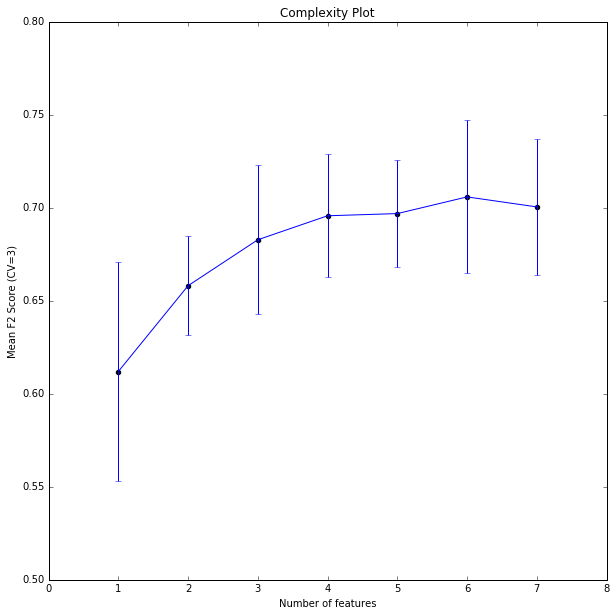

In [29]:
k_features, DF = wrapper(estimator, X_train, y_train, max_features= 15, show_max= False, steps_down=1)

In [30]:
print(DF.head())

   n_features  F2_score     F2_SD                                 Features
0           1  0.611989  0.058733                                    [GNE]
1           2  0.658109  0.026748                            [GNE, DONSON]
2           3  0.682818  0.040039                     [GNE, DONSON, KIF3A]
3           4  0.695718  0.032962          [GNE, DONSON, KIF3A, HIST1H2AK]
4           5  0.696886  0.028685  [GNE, DONSON, KIF3A, HIST1H2AK, INCENP]


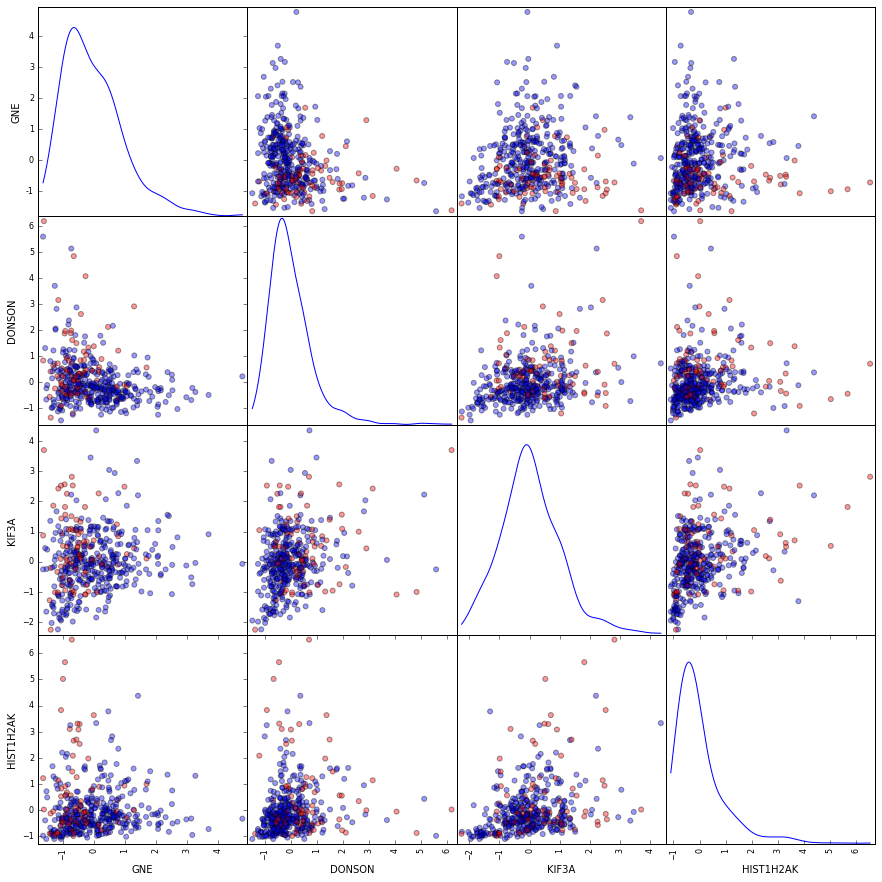

In [31]:
best_genes = DF.loc[3, 'Features']
sm = pd.scatter_matrix(X_scaled.loc[:,best_genes], #Chose to use the first 4 features selected in previous
                       alpha=0.4, 
                       figsize= (15,15), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

### Univariate SVM Model Refinement

In [32]:
estimator = SVC(C=1,
                kernel='linear',
                probability=True,
                tol=0.001,
                cache_size=200,
                gamma = 'auto',
                class_weight='balanced',
                verbose=False,
                max_iter=-1,
                random_state= 123)

clf_search = GridSearchCV(estimator,
                   param_grid = {'kernel':['rbf','linear'],
                                 'C': [1,0.5, 0.1]},
                   scoring=fbeta_scorer,
                   fit_params=None,
                   n_jobs=1,
                   iid=True,
                   refit=True,
                   cv= 5,
                   verbose=0,
                   pre_dispatch='2*n_jobs',
                   error_score='raise')

In [33]:
clf_search.fit(X_train.loc[:,best_genes], y_train)
clf_svm_fr = clf_search.best_estimator_
print('\n',clf_svm_fr,'\n')
print(classification_report(y_train,
                            clf_svm_fr.predict(X_train.loc[:,best_genes]),
                            target_names = ['n0', 'n1']))
print('\nF beta: ', fbeta_score(y_train, clf_svm_fr.predict(X_train.loc[:,best_genes]), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_train, clf_svm_fr.predict(X_train.loc[:,best_genes])))


 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=123, shrinking=True,
  tol=0.001, verbose=False) 

             precision    recall  f1-score   support

         n0       0.94      0.69      0.80       287
         n1       0.38      0.80      0.51        66

avg / total       0.83      0.71      0.74       353


F beta:  0.654320987654

MCC:  0.395162781013


### Determine the Best Principle Components for SVM classifiction

In [34]:
estimator = SVC(C=1,
                kernel='linear',
                probability=False,
                tol=0.01,
                cache_size=200,
                gamma = 'auto',
                class_weight='balanced',
                verbose=False,
                max_iter=-1,
                random_state= 123)

In [35]:
print(estimator, Xpca_train.shape, ypca_train.shape)
print(X_train.shape, y_train.shape)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.01, verbose=False) (353, 423) (353,)
(353, 1863) (353,)


/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ccthomps/anaconda/lib/python3.5/site-packages

Iteration:  1  complete!
Iteration:  2  complete!
Iteration:  3  complete!
Iteration:  4  complete!
Iteration:  5  complete!
Iteration:  6  complete!
Iteration:  7  complete!
Iteration:  8  complete!
Iteration:  9  complete!
Iteration:  10  complete!


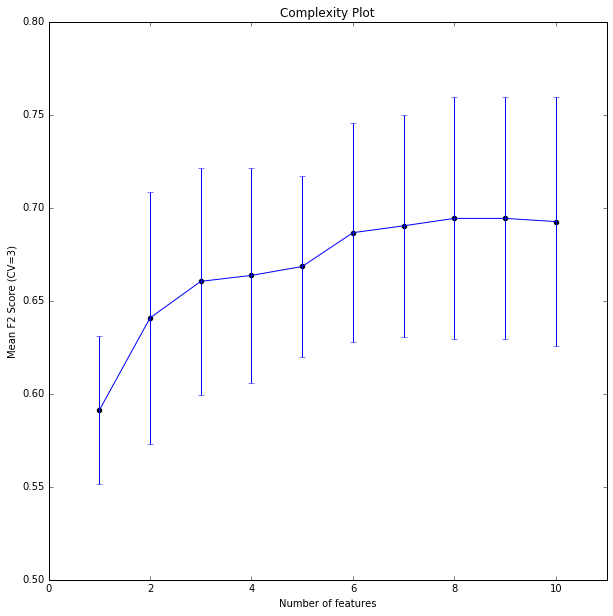

In [36]:
k_components, DF_pca = wrapper(estimator, Xpca_train, ypca_train, max_features= 15, show_max= False, steps_down=1)

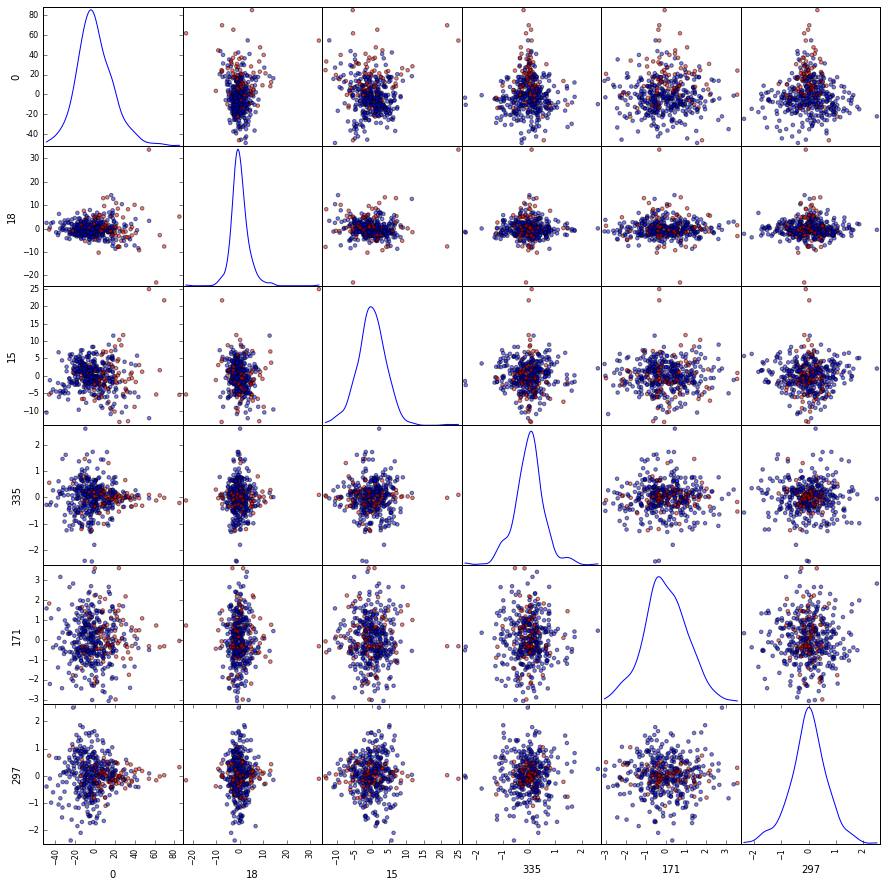

In [37]:
best_components = DF_pca.loc[5,'Features']
sm = pd.scatter_matrix(X_pca.loc[:,best_components], #Choose to use the best x principle components                        alpha=0.4, 
                       figsize= (15,15), 
                       diagonal = 'kde', 
                       c = y.replace({'n1':'red','n0':'blue'}), 
                       s = 50)

### Primary Components SVM Refinement

In [38]:
estimator = SVC(C=1,
                kernel='linear',
                probability=True,
                tol=0.001,
                cache_size=200,
                gamma = 'auto',
                class_weight='balanced',
                verbose=False,
                max_iter=-1,
                random_state= 123)

clf_search_pca = GridSearchCV(estimator,
                   param_grid = {'kernel':['rbf','linear'],
                                 'C': [1,0.5, 0.1]},
                   scoring=fbeta_scorer,
                   fit_params=None,
                   n_jobs=1,
                   iid=True,
                   refit=True,
                   cv= 5,
                   verbose=0,
                   pre_dispatch='2*n_jobs',
                   error_score='raise')

In [39]:
clf_search_pca.fit(Xpca_train.loc[:,best_components], ypca_train)
clf_svm_fr_pca = clf_search_pca.best_estimator_

print('\n',clf_svm_fr_pca,'\n')
print(classification_report(ypca_train,
                            clf_svm_fr_pca.predict(Xpca_train.loc[:,best_components]),
                            target_names = ['n0', 'n1']))
print('\nF beta: ', fbeta_score(ypca_train, clf_svm_fr_pca.predict(Xpca_train.loc[:,best_components]), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(ypca_train, clf_svm_fr_pca.predict(Xpca_train.loc[:,best_components])))

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=123, shrinking=True,
  tol=0.001, verbose=False) 

             precision    recall  f1-score   support

         n0       0.94      0.76      0.84       287
         n1       0.43      0.77      0.55        66

avg / total       0.84      0.76      0.79       353


F beta:  0.665796344648

MCC:  0.44190501169


### AdaBoost

In [40]:
%run -i AdaBoost/adaboost.py
print('\n',ada_clf,'\n')

             precision    recall  f1-score   support

         n0       0.94      0.55      0.69       287
         n1       0.30      0.85      0.44        66

avg / total       0.82      0.60      0.65       353

F beta:  0.622222222222

MCC:  0.308866029251

 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=123) 



### Random Forest

In [41]:
%run -i Random_Forest/RF.py

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

              precision    recall  f1-score   support

         n0       0.95      0.90      0.92       287
         n1       0.65      0.77      0.70        66

avg / total       0.89      0.88      0.88       353


F beta:  0.743440233236

MCC:  0.631589416818


### Logistic Regression

In [42]:
%run -i LogReg_gleason/LogReg_GS.py

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

         n0       0.94      0.66      0.78       287
         n1       0.35      0.80      0.49        66

avg / total       0.83      0.69      0.72       353


F beta:  0.640096618357

MCC:  0.366792160925


/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## Test for the best model

In [43]:
print(classification_report(y_test,
                            LR_clf.predict(logisticDF_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, LR_clf.predict(logisticDF_test), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, LR_clf.predict(logisticDF_test)))

             precision    recall  f1-score   support

         n0       0.95      0.67      0.79        58
         n1       0.37      0.85      0.51        13

avg / total       0.84      0.70      0.74        71

F beta:  0.670731707317

MCC:  0.406011681267


In [44]:
print(classification_report(ypca_test,
                            clf_svm.predict(Xpca_test),
                            target_names = ['n0', 'n1']))

print('F beta: ', fbeta_score(ypca_test, clf_svm.predict(Xpca_test), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(ypca_test, clf_svm.predict(Xpca_test)))

             precision    recall  f1-score   support

         n0       0.92      0.98      0.95        58
         n1       0.89      0.62      0.73        13

avg / total       0.91      0.92      0.91        71

F beta:  0.655737704918

MCC:  0.695302465667


In [45]:
print(classification_report(ypca_test,
                            clf_svm_fr_pca.predict(Xpca_test.loc[:,best_components]),
                            target_names = ['n0', 'n1']))

print('F beta: ', fbeta_score(ypca_test, clf_svm_fr_pca.predict(Xpca_test.loc[:,best_components]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(ypca_test, clf_svm_fr_pca.predict(Xpca_test.loc[:,best_components])))

             precision    recall  f1-score   support

         n0       0.96      0.76      0.85        58
         n1       0.44      0.85      0.58        13

avg / total       0.86      0.77      0.80        71

F beta:  0.714285714286

MCC:  0.489700164101


In [46]:
print(classification_report(y_test,
                            clf_svm_fr.predict(X_test.loc[:,best_genes]),
                            target_names = ['n0', 'n1']))

print('F beta: ', fbeta_score(y_test, clf_svm_fr.predict(X_test.loc[:,best_genes]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, clf_svm_fr.predict(X_test.loc[:,best_genes])))

             precision    recall  f1-score   support

         n0       0.91      0.71      0.80        58
         n1       0.35      0.69      0.46        13

avg / total       0.81      0.70      0.73        71

F beta:  0.576923076923

MCC:  0.320470377384


In [47]:
print(classification_report(y_test,
                            RF_clf.predict(X_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, RF_clf.predict(X_test), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, RF_clf.predict(X_test)))

             precision    recall  f1-score   support

         n0       0.91      0.91      0.91        58
         n1       0.62      0.62      0.62        13

avg / total       0.86      0.86      0.86        71

F beta:  0.615384615385

MCC:  0.529177718833


In [48]:
print(classification_report(y_test,
                            ada_clf.predict(X_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, ada_clf.predict(X_test), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, ada_clf.predict(X_test)))

             precision    recall  f1-score   support

         n0       0.88      0.66      0.75        58
         n1       0.29      0.62      0.39        13

avg / total       0.77      0.65      0.69        71

F beta:  0.5

MCC:  0.214107189661


## Generate a Voting Classifier and Test for performance

In [97]:
clf_dict = {'SVM_fr' : {'model': clf_svm_fr, 
                          'input_set': X_train.loc[:,best_genes], 
                          'label_set' : y_train, 
                          'weight' : .5}, 
            'SVM_fr_pca' : {'model': clf_svm_fr_pca, 
                          'input_set': Xpca_train.loc[:,best_components], 
                          'label_set' : ypca_train, 
                          'weight' : 1}, 
            'AdaBoost' : {'model': ada_clf, 
                          'input_set': X_train, 
                          'label_set' : y_train, 
                          'weight' : 0}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_train, 
                          'label_set' : y_train, 
                          'weight' : .5}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF, 
                          'label_set' : y_train, 
                          'weight' : .5}, 
            'SVM' : {'model': clf_svm, 
                          'input_set': Xpca_train, 
                          'label_set' : ypca_train, 
                          'weight' : 0}}
test_dict = {'SVM_fr' : {'model': clf_svm_fr, 
                          'input_set': X_test.loc[:,best_genes], 
                          'label_set' : y_test, 
                          'weight' : .5}, 
            'SVM_fr_pca' : {'model': clf_svm_fr_pca, 
                          'input_set': Xpca_test.loc[:,best_components], 
                          'label_set' : y_test, 
                          'weight' : 1}, 
            'AdaBoost' : {'model': ada_clf, 
                          'input_set': X_test, 
                          'label_set' : y_test, 
                          'weight' : 0}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_test, 
                          'label_set' : y_test, 
                          'weight' : .5}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF_test, 
                          'label_set' : y_test, 
                          'weight' : .5}, 
            'SVM' : {'model': clf_svm, 
                          'input_set': Xpca_test, 
                          'label_set' : ypca_test, 
                          'weight' : 0}}

In [98]:

def voter(clf_dict, threshold=0.5, verbose = True) :
    """Test labels are in same order"""
    pass
    
    df = pd.DataFrame()
    weights = []
    for model in clf_dict.items() :
        #print(model[0])
        df[model[0]] = model[1]['model'].predict_proba(model[1]['input_set'])[:,1]
        #index = model[1]['label_set'].index
        #df[model[0]].replace({'n1':1,'n0':0}, inplace = True)
        df[model[0]] = df[model[0]].apply(lambda x : x*model[1]['weight'])
        weights.append(model[1]['weight'])
    df.set_index(clf_dict['SVM']['label_set'].index, inplace=True)
    #print(weights)
    df['Weighted_Vote'] = df.apply(lambda x : sum(x)/np.sum(weights), axis = 1)
    df['actual_y'] = list(clf_dict['SVM']['label_set'])
    df['called_y'] = df['Weighted_Vote'].apply(lambda x : x >= threshold)
    df['called_y'] = df['called_y'].replace({False : 'n0', True : 'n1'})
    #print(df.tail(10)) #[Debug]
    if verbose == True :
        print('\nClass_report:\n ',classification_report(df['actual_y'], df['called_y']))
        print('\nF beta: ',fbeta_score(df['actual_y'], df['called_y'], beta = 2, pos_label='n1'))
        print('\nMCC: ',matthews_corrcoef(df['actual_y'], df['called_y']))
    return(fbeta_score(df['actual_y'], df['called_y'], beta = 2, pos_label='n1'),
           matthews_corrcoef(df['actual_y'], df['called_y']))


In [99]:
F2_train, MCC_train = voter(clf_dict, 0.37, verbose=True)


Class_report:
               precision    recall  f1-score   support

         n0       0.92      0.87      0.90       287
         n1       0.55      0.68      0.61        66

avg / total       0.85      0.84      0.84       353


F beta:  0.650289017341

MCC:  0.510465758945


In [100]:
"""Find appropriate voting threshold"""
#TH = pd.DataFrame(columns= ['Threshold', 'F2'])
temp_list = []
for x in np.arange(0.01, .99, 0.01) :
    temp_list.append({'Threshold': x, 'F2': voter(clf_dict, x, verbose=False)[0], 'MCC':voter(clf_dict, x, verbose=False)[1] })

Train_TH = pd.DataFrame(temp_list, columns = ['Threshold', 'F2', 'MCC'])

temp_list = []
for x in np.arange(0.01, .99, 0.01) :
    temp_list.append({'Threshold': x, 'F2': voter(test_dict, x, verbose=False)[0], 'MCC':voter(test_dict, x, verbose=False)[1] })

Test_TH = pd.DataFrame(temp_list, columns = ['Threshold', 'F2', 'MCC'])
    

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<function matplotlib.pyplot.show>

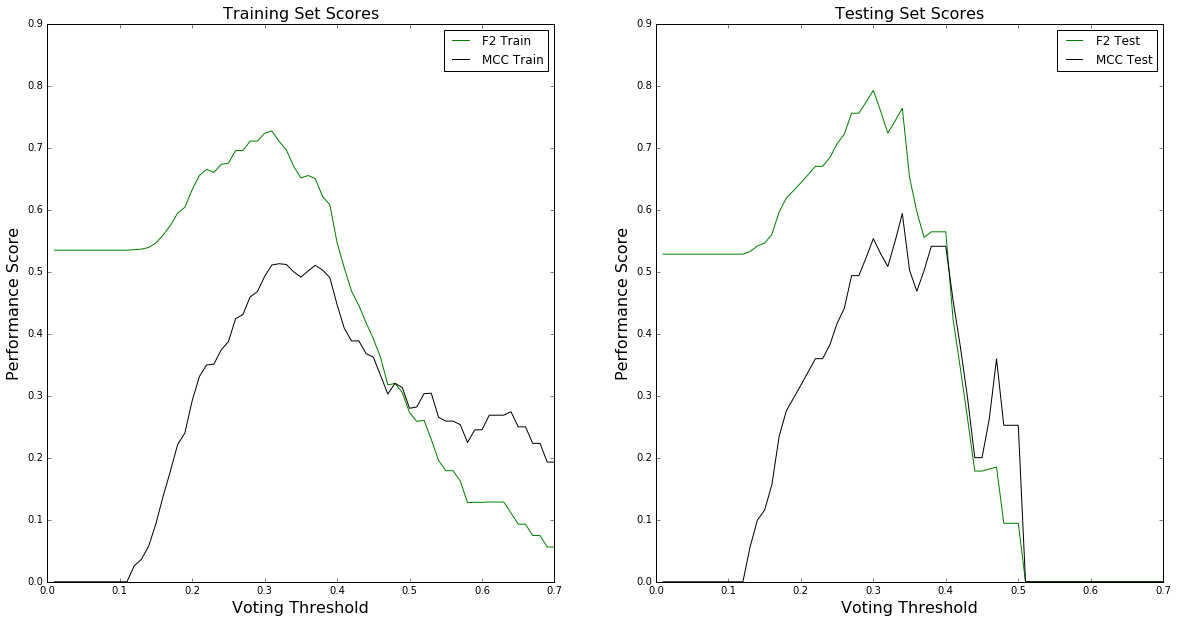

In [101]:
TH_fig = plt.figure(figsize=(20,10))
A = TH_fig.add_subplot(1,2,1)
B = TH_fig.add_subplot(1,2,2)
A.plot(Train_TH['Threshold'], Train_TH['F2'], color = 'green', label='F2 Train')
A.plot(Train_TH['Threshold'], Train_TH['MCC'], color = 'black', label = 'MCC Train')
B.plot(Test_TH['Threshold'], Test_TH['F2'], color = 'green', label = 'F2 Test')
B.plot(Test_TH['Threshold'], Test_TH['MCC'], color = 'black', label = 'MCC Test')
A.legend(loc='best')
B.legend()
A.set_ylim(0,.9)
A.set_xlim(0,0.7)
B.set_xlim(0,0.7)
B.set_ylim(0,.9)
A.set_title('Training Set Scores', fontsize=16)
B.set_title('Testing Set Scores', fontsize=16)
A.set_ylabel('Performance Score', fontsize=16)
B.set_ylabel('Performance Score', fontsize=16)
A.set_xlabel('Voting Threshold', fontsize=16)
B.set_xlabel('Voting Threshold', fontsize=16)
plt.show
    

In [105]:
F2, MCC = voter(test_dict, threshold=0.333, verbose=True)


Class_report:
               precision    recall  f1-score   support

         n0       0.96      0.83      0.89        58
         n1       0.52      0.85      0.65        13

avg / total       0.88      0.83      0.84        71


F beta:  0.753424657534

MCC:  0.570930691273
